In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

passenger_id=test['PassengerId']

# drop PassengerID and Ticket because I think its not relevant
train.drop(['PassengerId','Ticket','Name'], axis=1, inplace=True)
test.drop(['PassengerId','Ticket','Name'], axis=1, inplace=True)


In [3]:
def detect_outliers(df,n,features):
    #remove outliers using the Tukey method. as outliers might affect the result if it's not removed
    
    indices = []
    
    # iterate over features(columns)
    for col in features:

        Q1 = np.percentile(df[col], 25)

        Q3 = np.percentile(df[col],75)

        IQR = Q3 - Q1

        step = 1.5 * IQR
        
        list_col = df[(df[col] < Q1 - step) | (df[col] > Q3 + step )].index
        
        indices.extend(list_col)
        
    indices = Counter(indices)        
    multiple_outliers = list( k for k, v in indices.items() if v > n )
    
    return multiple_outliers   

drop_outliers = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

C:\Miniconda3\envs\tensorflow\lib\site-packages\numpy\lib\function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [4]:
train = train.drop(drop_outliers, axis = 0).reset_index(drop=True)

In [5]:
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)
len_train = len(train)

In [6]:
# fill the missing values with NaN
dataset = dataset.fillna(np.nan)
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


In [7]:
# change male/female to 1/0
dataset["Sex"] = dataset["Sex"].map({"male": 1.0, "female":0.0})
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


In [8]:
#fill the missing value of Fare with medians 
pd.options.display.max_columns = 99
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


In [9]:
# Create a family size descriptor
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallFamily'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedFamily'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeFamily'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

In [10]:
# fill the missing value of Embarked with the most frequent (S)
dataset["Embarked"] = dataset["Embarked"].fillna("S")
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

In [11]:
# fill the missing calue of Cabin with X
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

In [12]:
# extract the prefix (category) of the Cabin
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

In [13]:
# Filling missing value of Age 

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

C:\Miniconda3\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [14]:
train = dataset[:len_train]
test = dataset[len_train:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

C:\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
dataset = dataset.fillna(np.nan)
train["Survived"] = train["Survived"].astype(int)
Y_train = train["Survived"]
X_train = train.drop(labels = ["Survived"],axis = 1)

In [16]:
# Cross validate
kfold = StratifiedKFold(n_splits=5)

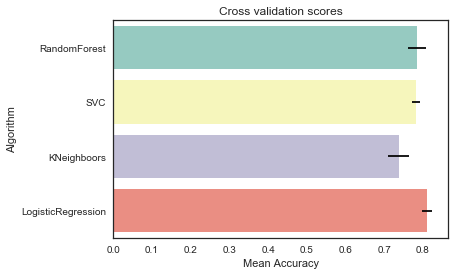

In [17]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["RandomForest","SVC","KNeighboors","LogisticRegression"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [18]:
# RFC Parameters tunning 
RFC = RandomForestClassifier(random_state=2)


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10, 'auto'],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False, True],
              "n_estimators" :[10,100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

print (gsRFC.best_params_)
print (gsRFC.best_score_)
print(gsRFC.best_estimator_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   33.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   55.9s
[Parallel(n_jobs=4)]: Done 1080 out of 1080 | elapsed:  1.3min finished


{'max_features': 10, 'n_estimators': 100, 'max_depth': None, 'min_samples_split': 10, 'bootstrap': True, 'min_samples_leaf': 1, 'criterion': 'gini'}
0.83200908059
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=2, verbose=0, warm_start=False)


In [19]:
### SVC classifier
SVMC = SVC(random_state=2)
svc_param_grid = {'kernel': ['rbf'], 
                  'probability': [True, False],
                  'gamma': [ 0.001, 0.01, 0.1, 1, 'auto'],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

print (gsSVMC.best_params_)
print (gsSVMC.best_score_)
print(gsSVMC.best_estimator_)

Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=4)]: Done  49 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 343 out of 350 | elapsed:   15.6s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 350 out of 350 | elapsed:   16.3s finished


{'gamma': 0.001, 'C': 1000, 'probability': True, 'kernel': 'rbf'}
0.828603859251
SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=2, shrinking=True, tol=0.001,
  verbose=False)


In [20]:
### Logistic Regression
logreg = LogisticRegression(random_state = 2)
C_vals = [0.0001, 0.001, 0.01, 0.1,0.13,0.2, .15, .25, .275, .33, 0.5, .66, 0.75, 1.0, 2.5, 4.0,4.5,5.0,5.1,5.5,6.0, 10.0, 100.0, 1000.0]
penalties = ['l1','l2']

param = {'penalty': penalties, 'C': C_vals, }
gLR = GridSearchCV(logreg, param_grid = param, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gLR.fit(X_train,Y_train)
print (gLR.best_params_)
print (gLR.best_score_)
print(gLR.best_estimator_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'penalty': 'l1', 'C': 10.0}
0.814982973893
LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=2, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed:    3.9s finished
